In [1]:
reset -fs

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from joblib import load
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report

/home/vietpride12/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
%matplotlib inline

# Predicting New York Times Section Names

By: Phil Trinh, Nina Hua, Jacques Sham, Evan Liu, Paul Kim

# Goal:
Our goal in this project was to predict the section that the article lives under (i.e. Sports, Politics, Media, etc.)


Here's a look at some data we were working with:

In [5]:
import numpy as np
import pandas as pd

articles = 'Data/ArticlesApril2018.csv'
arts = pd.read_csv(articles)
arts.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [6]:
comments = 'Data/CommentsApril2018.csv'
comm = pd.read_csv(comments)

comm.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,<br/>,comment,1524594011,1.0,...,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,NaN
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,<br/>,comment,1524593146,1.0,...,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,NaN
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,<br/>,comment,1524593032,1.0,...,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,NaN
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,<br/>,comment,1524593426,1.0,...,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,NaN
4,1524595048,5adf653f068401528a2aa697,656.0,Seeking conclusions which support preconceived...,26854236.0,26854236.0,<br/>,comment,1524595043,1.0,...,approved,1,0,News,1524595048,Paul Zorsky,58642997.0,Texas,NaN,NaN


The pre-processing we did was to take out the 'Unknown' and NA section names and ensure the comment type was 'comment' rather than 'userReply'. 

These were the initial efforts to minimize noise - later, we implemented pre-processing to handle 'Unknown's. More on this later.

# Modeling Methodology

1. Try modeling using 1 month of data, select the best model, then train on 9 months of data.
2. Use commentBody to predict the section name.
3. Use newDesk and typeOfMaterial to predict.
4. Pre-processing: Removed the 'Unknown' sections and the 'userReply' comment types.
5. Vectorized our features and used pipeline
6. Performed GridSearchCV.


From grid search, pulled the best parameters

The models that we tried:
1. Logistic Regression
2. Naive Bayes
3. SVM
4. Boosting

# Let's take a look at some models!

In [7]:
# Comments File
comments_file = 'Data/CommentsApril2018.csv'

# Read in File
comments = pd.read_csv(comments_file)

# Filter out articles with "Unknown" Section Name
filt = (comments.sectionName != "Unknown") & (comments.commentType == "comment") & comm.sectionName.notna()
data = comments.commentBody[filt]
sections = comments.sectionName[filt]

# Train/Test Split
train_data, test_data, train_target, test_target = train_test_split(data, sections)

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(list(set(comm.sectionName[filt])))

data_lgr = comm.commentBody[filt]
sections_lgr = le.transform(comm.sectionName[filt])
train_data_lgr, test_data_lgr, train_target_lgr, test_target_lgr = train_test_split(data_lgr, sections_lgr)

vectorizer = CountVectorizer(decode_error='ignore',
                             stop_words='english')

lgr_model = Pipeline([('vec', vectorizer),
                    ('clf', LogisticRegression(solver='sag',
                                               multi_class='multinomial'))])
 

In [9]:
lgr_model.fit(train_data_lgr,train_target_lgr)

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s... penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [10]:
lgr_model.score(test_data_lgr,test_target_lgr)

0.7208864210995984

## Naive Bayes

So Naive Bayes was kind of our step up from Logistic Regression and the natural progression as we were working with text data. We performed grid search on Naive Bayes on the alpha value as well as the ngram value, and ended up with an alpha value of .3 and ngram of 1.

In [11]:
nb_model = load('Models/naive_bayes_small.joblib') 

In [12]:
nb_model.score(test_data, test_target)

0.8017450795696792

In [13]:
vectorizer = CountVectorizer(decode_error='ignore',
                             stop_words='english')

booster_NB_model = Pipeline([('vec', vectorizer),
                    ('boo', AdaBoostClassifier(nb_model.get_params()['clf']))])

booster_NB_model.fit(train_data, train_target)

booster_NB_model.score(test_data, test_target)

0.5679936542561103

In [14]:
predictions = nb_model.predict(test_data)
print(classification_report(test_target, predictions))

                        precision    recall  f1-score   support

                Africa       1.00      0.50      0.67        62
              Americas       0.83      0.52      0.64       228
          Art & Design       0.93      0.58      0.72        74
          Asia Pacific       0.69      0.74      0.71       963
             Australia       1.00      0.21      0.35        19
           Book Review       0.80      0.47      0.59       175
                Canada       0.90      0.77      0.83       144
    College Basketball       1.00      0.58      0.73        19
               Cycling       1.00      0.36      0.53        33
              DealBook       0.80      0.70      0.74        73
                   Eat       0.84      0.74      0.78        99
               Economy       0.61      0.73      0.66       299
                Europe       0.75      0.58      0.65       695
                Family       0.76      0.82      0.79       354
                  Golf       1.00      

## SVM

In [15]:
lsvc_model = load('Models/svm_small.joblib')

In [16]:
lsvc_model.score(test_data, test_target)

0.9227603985920381

In [17]:
vectorizer = TfidfVectorizer(input='content',
                            analyzer='word',
                            stop_words='english',
                            decode_error='ignore')

booster_LSVC_model = Pipeline([('vec', vectorizer),
                               ('boo', AdaBoostClassifier(lsvc_model.get_params()['clf'], algorithm='SAMME'))])

booster_LSVC_model.fit(train_data, train_target)

booster_LSVC_model.score(test_data, test_target)

0.7633731594863914

## Which model performed the best?

### Yeah, SVM!
Let's take a look at how it performs on all the comment data.

In [18]:
# Full Comments File
comments_file = 'Data/combined_comments.csv'

# Read in File
comments = pd.read_csv(comments_file).drop('Unnamed: 0', axis=1)

# Filter out articles with "Unknown" Section Name
filt = (comments.sectionName != "Unknown") & (comments.commentType == "comment") & comments.sectionName.notna()
data = comments.commentBody[filt]
sections = comments.sectionName[filt]

# Train/Test Split
train_data, test_data, train_target, test_target = train_test_split(data, sections)

In [19]:
lsvc_full_model = load('Models/svm_full.joblib')

In [20]:
lsvc_full_model.score(test_data, test_target)

0.9311557753593112

In [21]:
vectorizer = TfidfVectorizer(input='content',
                            analyzer='word',
                            stop_words='english',
                            decode_error='ignore')

booster_LSVC_full_model = Pipeline([('vec', vectorizer),
                               ('boo', AdaBoostClassifier(lsvc_full_model.get_params()['clf'], algorithm='SAMME'))])

booster_LSVC_full_model.fit(train_data, train_target)

booster_LSVC_full_model.score(test_data, test_target)

0.7256361372382112

In [22]:
predictions = lsvc_full_model.predict(test_data)
print(classification_report(test_target, predictions))

                            precision    recall  f1-score   support

401(k)'s and Similar Plans       1.00      0.76      0.87        17
                    Africa       0.98      0.76      0.86       233
                  Americas       0.97      0.82      0.89      1233
                       Art       1.00      0.75      0.86        12
              Art & Design       0.98      0.90      0.94       898
              Asia Pacific       0.93      0.85      0.89      4432
                 Australia       0.95      0.81      0.88       104
               Auto Racing       1.00      0.78      0.88        18
               Automobiles       1.00      0.67      0.80         9
                  Baseball       0.96      0.93      0.95       541
               Book Review       0.99      0.78      0.87       431
                    Canada       0.97      0.83      0.90       401
        College Basketball       0.97      0.88      0.92       169
          College Football       1.00      0.75

# SVM continued: newDesk + material_label

In [23]:
# Full File
everything = 'Data/combined_everything.csv'

# Read in File
full_data = pd.read_csv(everything)

# Filter out articles with "Unknown" Section Name
filt = (full_data.sectionName != "Unknown") & (full_data.commentType == "comment")
full_filt = full_data[filt].copy().reset_index()

In [24]:
# Transform and map newDesk categories 
newDesk_le = LabelEncoder()
newDesk_labels = newDesk_le.fit_transform(full_filt['newDesk'])
full_filt['newDesk_label'] = newDesk_labels

# Encoding newDesk
newDesk_ohe = OneHotEncoder()
newDesk_feature_arr = newDesk_ohe.fit_transform(full_filt[['newDesk_label']]).toarray()
newDesk_feature_labels = list(newDesk_le.classes_)
newDesk_features = pd.DataFrame(newDesk_feature_arr, columns=newDesk_feature_labels)

# Transform and map typeOfMaterial categories 
material_le = LabelEncoder()
material_labels = material_le.fit_transform(full_filt['typeOfMaterial'])
full_filt['material_label'] = material_labels

# Encoding typeOfMaterial
material_ohe = OneHotEncoder()
material_feature_arr = material_ohe.fit_transform(full_filt[['material_label']]).toarray()
material_feature_labels = list(material_le.classes_)
material_features = pd.DataFrame(material_feature_arr, columns=material_feature_labels)

# Subsetting comment data frame and concatenating with new features
full_filt_sub = full_filt.loc[:,['commentBody', 'sectionName']]
full_df_ohe = pd.concat([full_filt_sub, newDesk_features, material_features], axis=1)

# Split to Data and Labels
data = full_df_ohe.loc[:,newDesk_feature_labels]
sections = full_df_ohe.sectionName

In [25]:
# Train/Test Split
train_data_no_unknown, test_data_no_unknown, train_target_no_unknown, test_target_no_unknown = train_test_split(data, sections)
train_target_no_unknown = train_target_no_unknown.astype(str)
test_target_no_unknown = test_target_no_unknown.astype(str)

In [26]:
lsvc_ohe_full_model = load('Models/ohe_linearsvm_full.joblib')

In [27]:
lsvc_ohe_full_model.score(test_data_no_unknown, test_target_no_unknown)

0.7232874279027

LDA is an unsupervised learning technique that is often used in topic modeling - was developed by Andrew Ng in 2003.
Didn't quite work - why?

## Dealing with Unknowns/The Issue of Class Imbalance

In [28]:
prediction_results = load('Models/prediction_results.joblib')
prediction_results

,Index,Training_count,Percent_training,Predict_count,Percent_predict,Percent_predict_more
0,Politics,310682,0.452751,408967,0.557028,1.042480e-01
1,Sunday Review,99848,0.145507,236518,0.322146,1.766357e-01
2,Europe,30698,0.044736,14010,0.019082,-2.565002e-02
3,Middle East,20678,0.030134,9913,0.013502,-1.663208e-02
4,Asia Pacific,17959,0.026171,6220,0.008472,-1.770020e-02
5,Media,12967,0.018897,5939,0.008089,-1.081085e-02
6,Family,10017,0.014598,12208,0.016628,2.029419e-03
7,Television,9343,0.013615,4505,0.006136,-7.480621e-03
8,Economy,7272,0.010597,7701,0.010489,-1.083016e-04
9,Live,6275,0.009144,6560,0.008935,-2.094507e-04


# Accuracy over # of data points

In [29]:
acc = pd.read_csv('Data/acc_datasize1.csv').drop('Unnamed: 0', axis=1)
df_summ = acc.groupby('size').agg({'acc':['mean','std']})
data = pd.DataFrame(df_summ)
data = data.reset_index()


(0.56, 0.72)

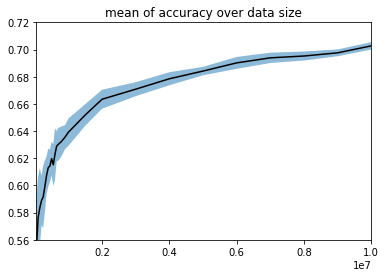

In [30]:
plt.figure()
plt.plot(data['size'],data.acc['mean'],color = 'black')
plt.fill_between(data['size'],data.acc['mean']+data.acc['std'],data.acc['mean']-data.acc['std'],alpha = .5)
plt.title('mean of accuracy over data size')
plt.margins(x = 0, y = -.025) #zoom
plt.ylim((.56,.72))

# Conclusion

1. SVM was the best model
2. Comments did end up being the best attribute for predicting section name
3. The big problem: Unknowns
4. And next time...
    Combine vectorized data for comments with other features
    
    Unsupervised learning on all features to see clusters
    
    PCA transformation on features
    
    Try to classify those unknowns